In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error)
import warnings
warnings.filterwarnings('ignore')
import itertools

plt.rcParams['figure.figsize'] = (20, 6)

In [2]:
# Creating a random time series dataset with 120 months data
np.random.seed(0)
date_range = pd.date_range(start='1/1/2010', periods=120, freq='M')
trend = np.linspace(50, 150, 120)
seasonality = 10 + 20 * np.sin(np.linspace(0, 3.14 * 2, 120)) # adding seasonal component
noise = np.random.normal(scale=10, size=120) # some random noises
data = trend + seasonality + noise
time_series = pd.Series(data, index=date_range)
time_series = pd.DataFrame(time_series)
# time_series.reset_index(inplace=True)
time_series.rename(columns={'index':'Date', 0:'Sales'}, inplace=True)
time_series.head()

,Sales
2010-01-31,77.640523
2010-02-28,65.896881
2010-03-31,73.575059
2010-04-30,88.083116
2010-05-31,86.227489


<Axes: >

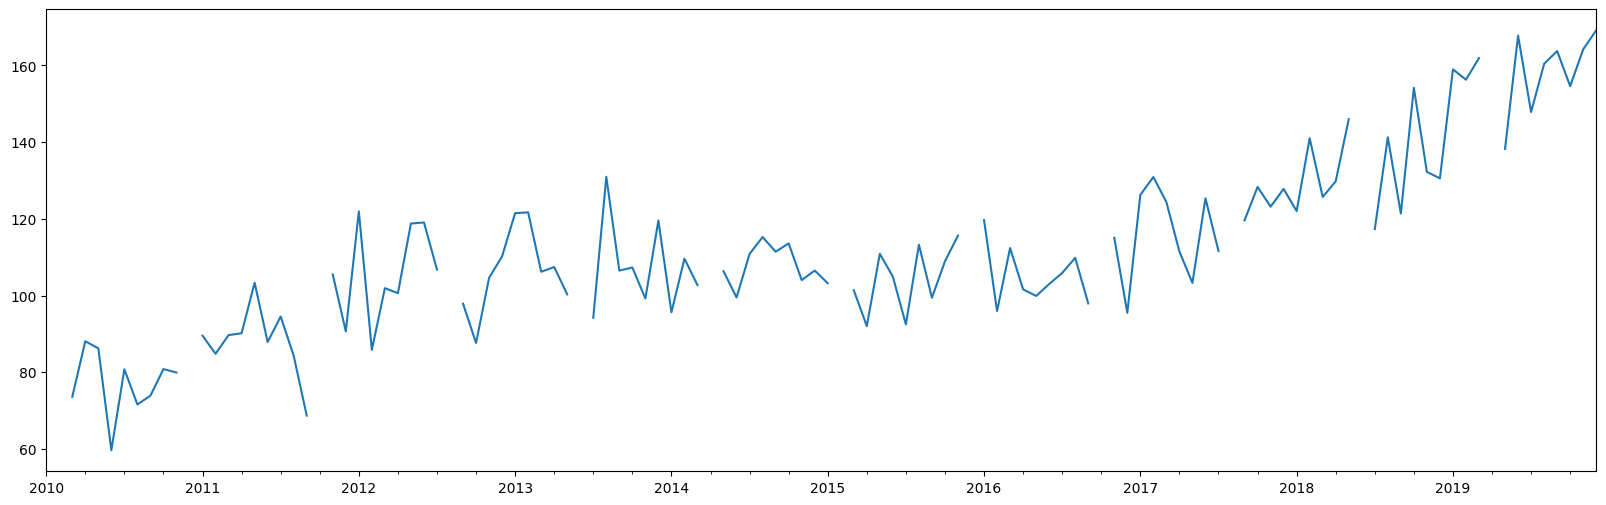

In [3]:
# Creating few NaN values in Data set. For Time Series Analysis data shouldn't contain any NaN values
time_series_with_nan = time_series.copy()
time_series_with_nan[1::10] = np.nan
time_series_with_nan.Sales.plot()

<Axes: >

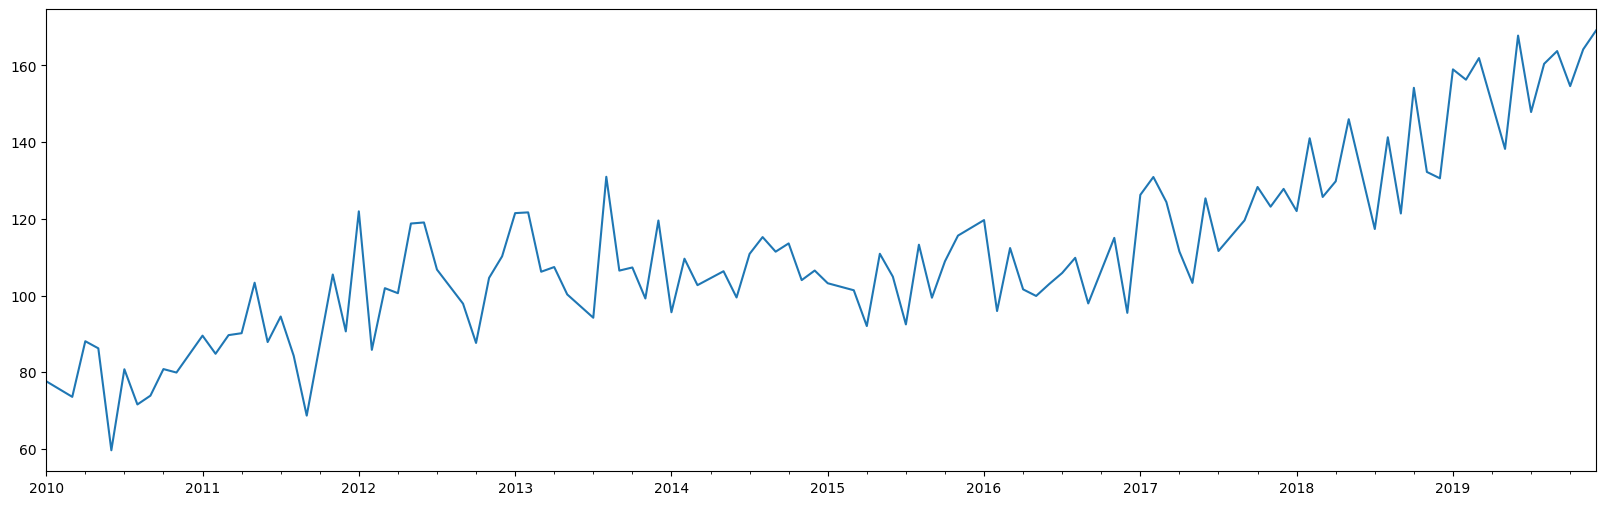

In [4]:
time_series_filled = time_series_with_nan.interpolate(method='linear')
time_series_filled.Sales.plot()

In [5]:
# Checking for any NaN values
time_series_filled.isna().sum()

Sales    0
dtype: int64

In [6]:
time_series_final = time_series_filled

In [7]:
time_series_filled

,Sales
2010-01-31,77.640523
2010-02-28,75.607791
2010-03-31,73.575059
2010-04-30,88.083116
2010-05-31,86.227489
...,...
2019-08-31,160.410385
2019-09-30,163.735442
2019-10-31,154.598879
2019-11-30,164.181873


In [8]:
time_series_final.Sales.describe()

count    120.000000
mean     110.974402
std       22.943199
min       59.645187
25%       96.918978
50%      106.634976
75%      121.964380
max      169.158361
Name: Sales, dtype: float64

In [9]:
time_series_final.head()

,Sales
2010-01-31,77.640523
2010-02-28,75.607791
2010-03-31,73.575059
2010-04-30,88.083116
2010-05-31,86.227489


<Axes: >

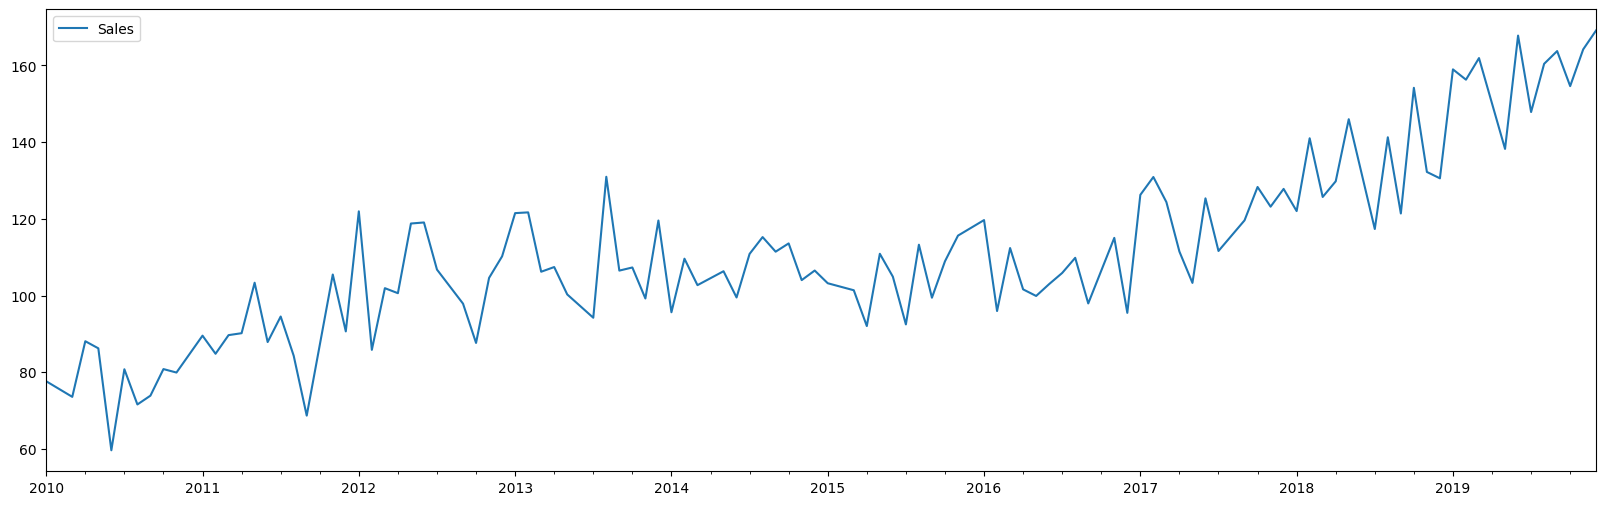

In [10]:
# Final Time Series Data
time_series_final.plot()

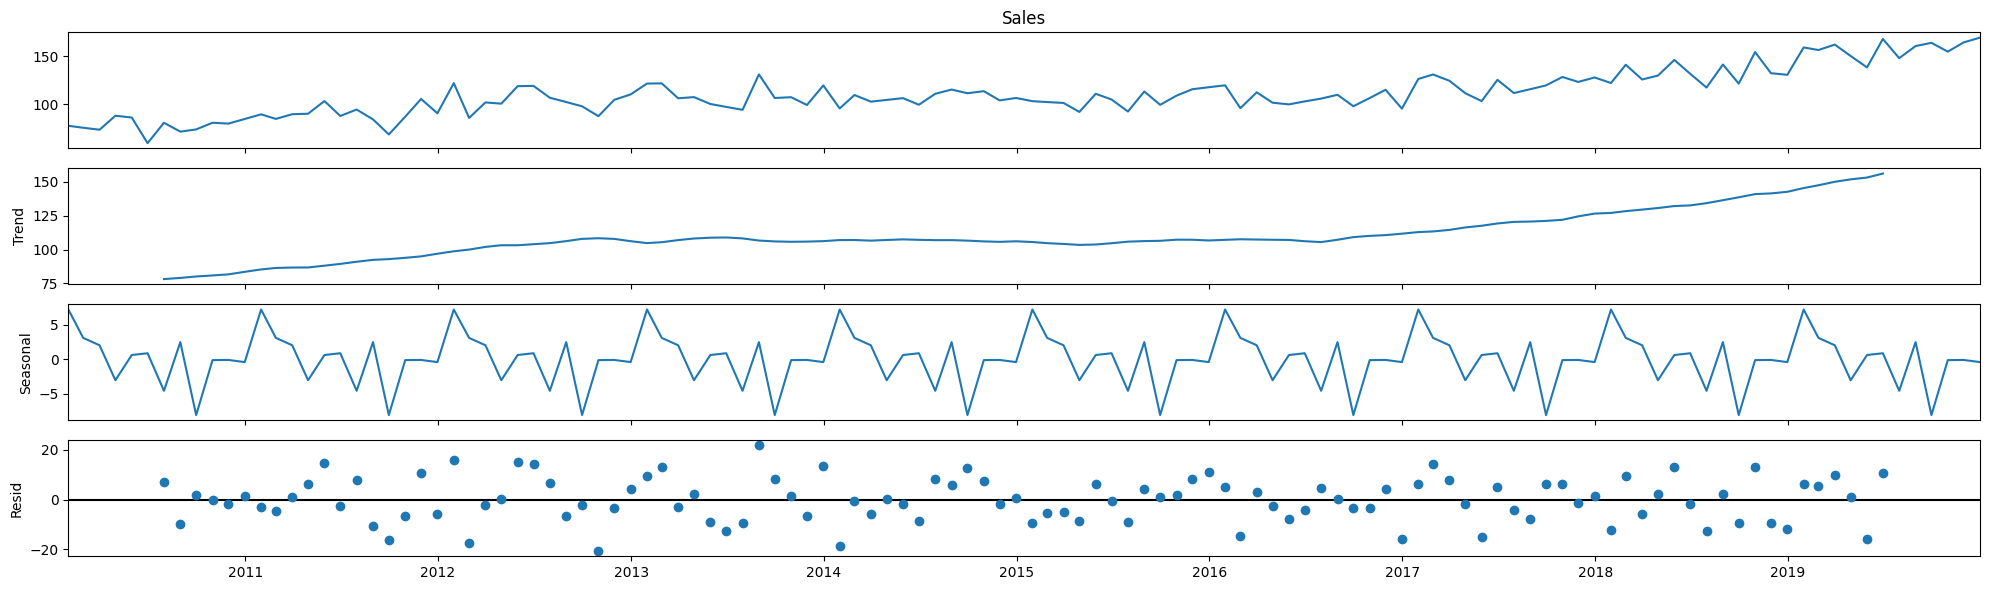

In [11]:
# Decomposing the entire dataset to get an idea of trend, seasonality, residue of Sales column
model = sm.tsa.seasonal_decompose(time_series_final.Sales, model='additive')
model.plot();
# Second grpah shows the trend of data and third is the seasonality  which is 12 months.

In [12]:
# spliting data for train and test
train_size = int(len(time_series_final)*0.85)
train_x = time_series_final[:train_size]
test_x = time_series_final[train_size:]

In [13]:
test_x.count()

Sales    18
dtype: int64

## Simple Exponential Smoothing

In [14]:
model_ses = SimpleExpSmoothing(train_x).fit(smoothing_level=0.25)

In [15]:
test_x['pred_ses'] = model_ses.forecast(24)

MAE : 20.474
RMSE : 23.344
MAPE : 0.132


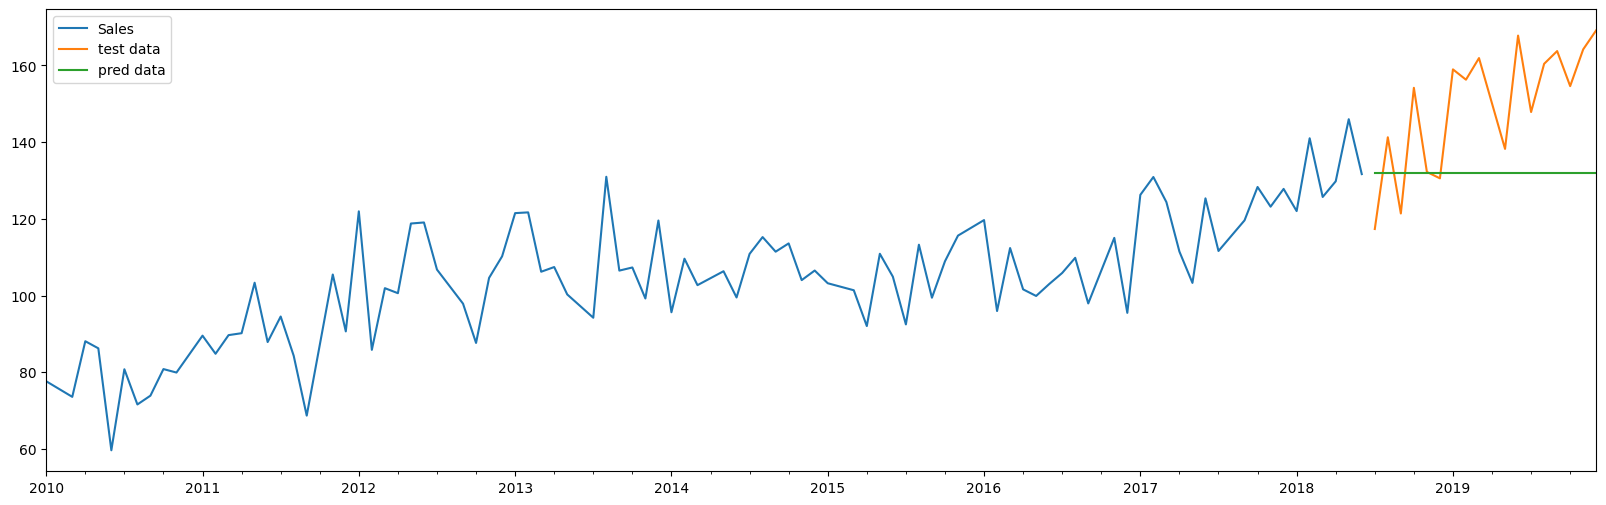

In [16]:
train_x.plot(label='train_data')
test_x.Sales.plot(label = 'test data')
test_x.pred_ses.plot(label = 'pred data')

plt.legend()

print("MAE :", round(mae(test_x.Sales, test_x.pred_ses),3))
print("RMSE :", round(mse(test_x.Sales, test_x.pred_ses)**0.5,3))
print("MAPE :", round(mean_absolute_percentage_error(test_x.Sales, test_x.pred_ses),3))

In [17]:
def performance(actual,predicted):
    print("MAE :", round(mae(actual, predicted),3))
    print("RMSE :", round(mse(actual, predicted)**0.5,3))
    print("MAPE :", round(mean_absolute_percentage_error(actual, predicted),3))

## Double Exponential Smoothing

MAE : 9.587
RMSE : 10.911
MAPE : 0.067


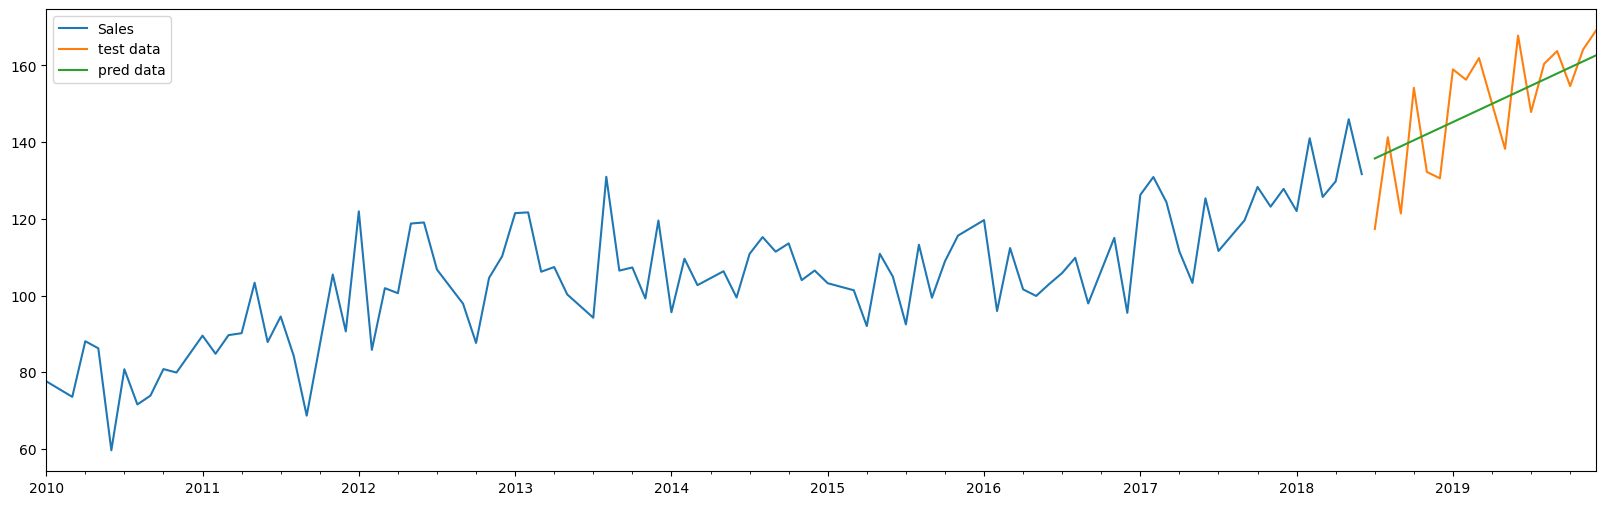

In [18]:
model_des = sm.tsa.ExponentialSmoothing(train_x, trend='add').fit()
test_x['pred_des'] = model_des.forecast(24)

train_x.plot(label='train_data')
test_x.Sales.plot(label = 'test data')
test_x.pred_des.plot(label = 'pred data')

plt.legend()

performance(test_x.Sales, test_x.pred_des)

## Triple Exponential Smoothing

MAE : 15.123
RMSE : 16.986
MAPE : 0.098


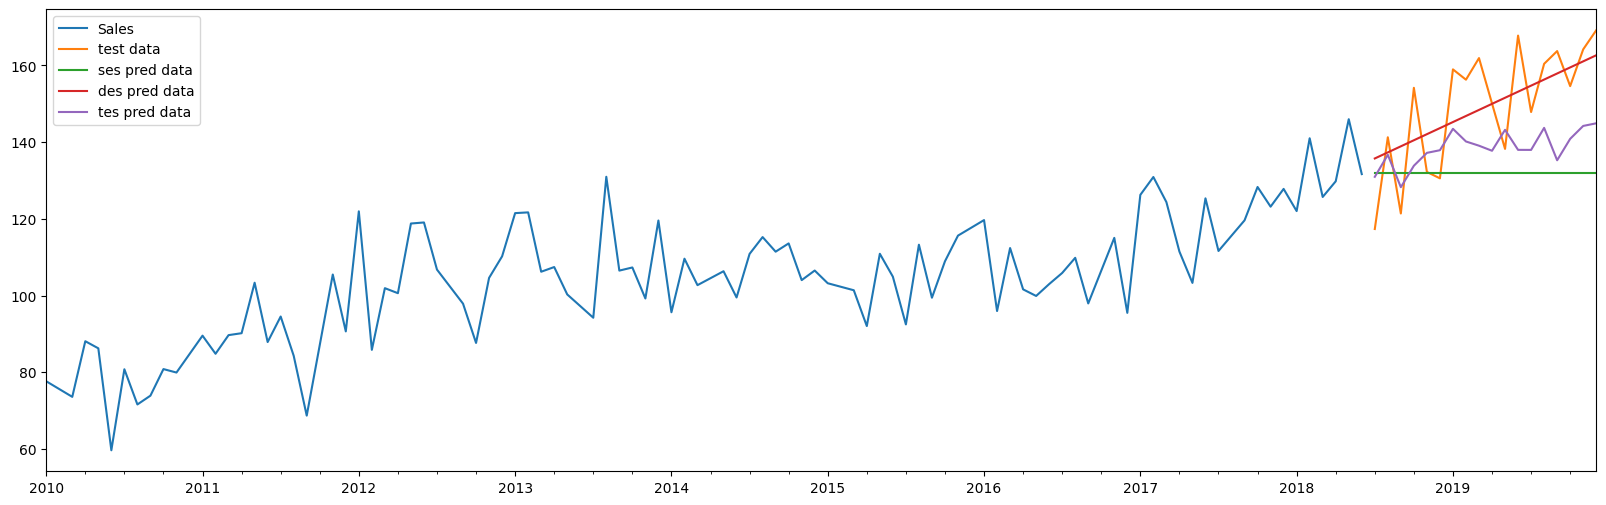

In [19]:
model_tes = sm.tsa.ExponentialSmoothing(train_x, trend='add', seasonal='add').fit(smoothing_level=0.25)
test_x['pred_tes'] = model_tes.forecast(steps=24)

train_x.plot(label='train_data')
test_x.Sales.plot(label = 'test data')
test_x.pred_ses.plot(label = 'ses pred data')
test_x.pred_des.plot(label = 'des pred data')
test_x.pred_tes.plot(label = 'tes pred data')

plt.legend()

performance(test_x.Sales, test_x.pred_tes)

## Stationarity of Data

Before creating ARIMA models the data has to be stationary, that means the data shouldn't have trend or seasonality. In order to make the data stationary, trend and seasonality has to be removed and that is done by differentiating the data. If we differentiate trend which is a straight line in th form y=mx+c then the slope is removed. Hence upon second differentiating seasonality is also removed and the resulting data is stationary. Dickey Fuller test can be used to check stationary of data. If p-value > significance level then it is not stationary, else it is. But of ARIMA, SARIMA and SARIMAX this can be done with the help of hyperparamter "d" which accepts value 0,1,2.

In [20]:
sm.tsa.stattools.adfuller(time_series_final.Sales)[1]

np.float64(0.9866578868311101)

In [21]:
sm.tsa.stattools.adfuller(time_series_final.Sales.diff(1).dropna())[1]

np.float64(4.740663538042183e-05)

In [22]:
sm.tsa.stattools.adfuller(time_series_final.Sales.diff(1).diff(1).dropna())[1]

np.float64(1.026504682744588e-09)

## ARIMA

MAE : 12.323
RMSE : 13.864
MAPE : 0.084


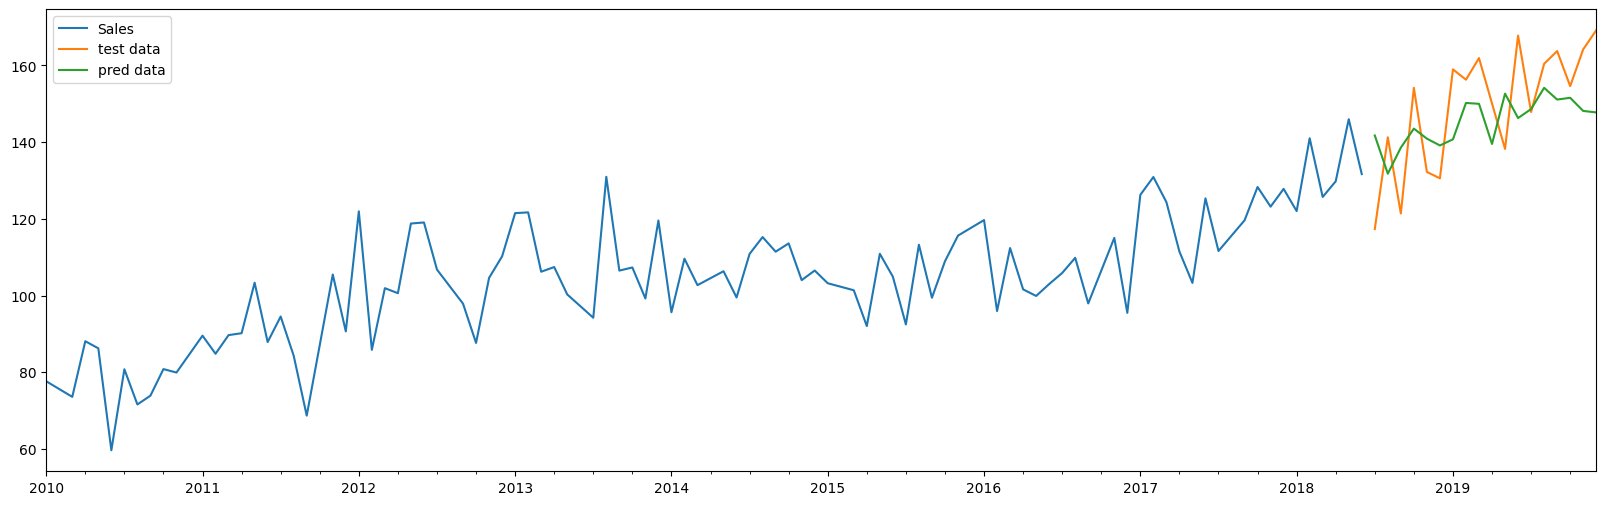

In [23]:
# ARIMA model can take parameters p,d and q which are p is the number of lag values considered, d is differentiations and q is moving avergae 

model_arima = SARIMAX(train_x.Sales, order = (27,2,12)).fit()
test_x['pred_data_arima'] = model_arima.forecast(24)

train_x.plot(label='train_data')
test_x.Sales.plot(label = 'test data')
test_x.pred_data_arima.plot(label = 'pred data')

plt.legend()

performance(test_x.Sales, test_x.pred_data_arima)

## SARIMA

MAE : 9.311
RMSE : 11.009
MAPE : 0.065


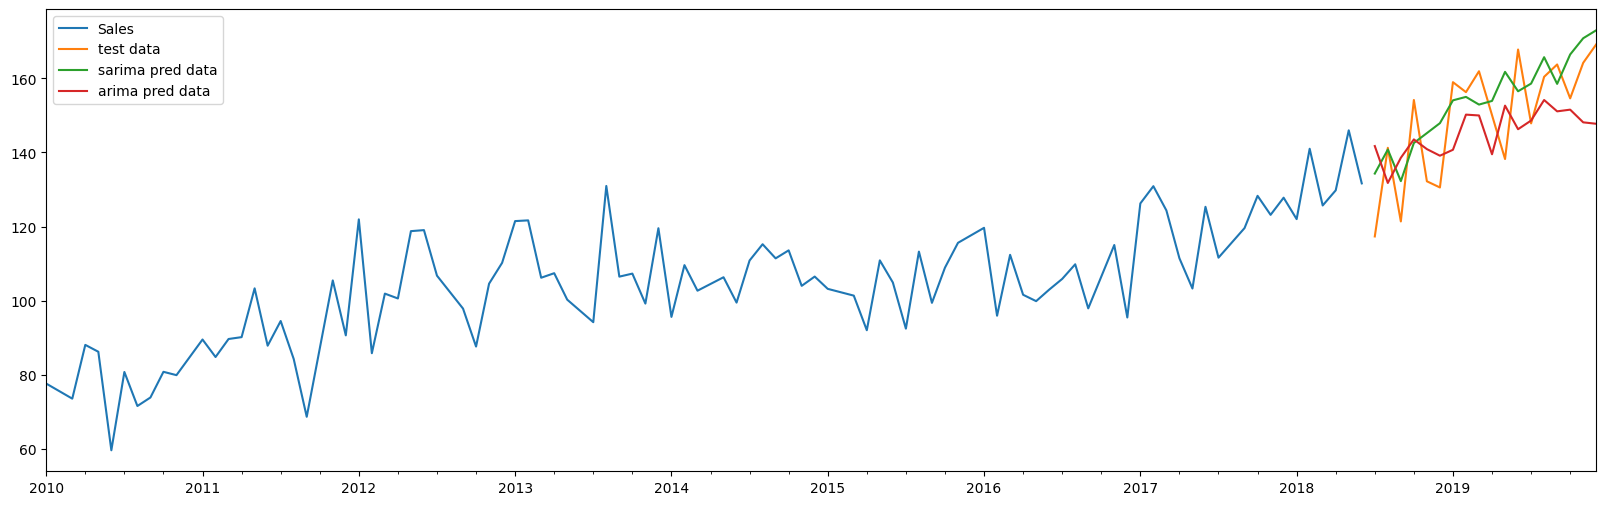

In [24]:
# In additon to ARIMA, SARIMA accepts sesonality as input and these paramters takes values between 0 to n, but till 5 is advisable, except s.

model_sarima = SARIMAX(train_x.Sales, order = (5,2,3), seasonal_order = (1,1,1,12)).fit()
test_x['pred_data_sarima'] = model_sarima.forecast(24)

train_x.plot(label='train_data')
test_x.Sales.plot(label = 'test data')
test_x.pred_data_sarima.plot(label = 'sarima pred data')
test_x.pred_data_arima.plot(label = 'arima pred data')

plt.legend()

performance(test_x.Sales, test_x.pred_data_sarima)

## Hyperparameter tuning SARIMA

In [25]:
test_x = test_x.drop(columns = ["pred_ses","pred_des","pred_tes","pred_data_arima","pred_data_sarima"])

In [26]:
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 2)

P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
S_values = [12]

param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values))

results = []

for params in param_grid:
    p, d, q, P, D, Q, S = params
    print(f"Trying parameters: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, S={S}")

    try:
        model = SARIMAX(train_x,
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, S),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

        model_fitted = model.fit(disp = False)
        forecast = model_fitted.forecast(steps=len(test_x))
        mape = mean_absolute_percentage_error(test_x, forecast)
        results.append((params, mape))

    except Exception as e:
        print(f"Error with parameters {params}: {e}")
        continue

if not results:
    print("No models fitted successfully")
else:
    results_df = pd.DataFrame(results, columns=['Parameters', 'MAPE'])
    best_params = results_df.loc[results_df['MAPE'].idxmin()]
    print(f"Best Parameters: {best_params['Parameters']} with MAPE: {best_params['MAPE']}")

Trying parameters: p=0, d=0, q=0, P=0, D=0, Q=0, S=12
Trying parameters: p=0, d=0, q=0, P=0, D=0, Q=1, S=12
Trying parameters: p=0, d=0, q=0, P=0, D=1, Q=0, S=12
Trying parameters: p=0, d=0, q=0, P=0, D=1, Q=1, S=12
Trying parameters: p=0, d=0, q=0, P=1, D=0, Q=0, S=12
Trying parameters: p=0, d=0, q=0, P=1, D=0, Q=1, S=12
Trying parameters: p=0, d=0, q=0, P=1, D=1, Q=0, S=12
Trying parameters: p=0, d=0, q=0, P=1, D=1, Q=1, S=12
Trying parameters: p=0, d=0, q=1, P=0, D=0, Q=0, S=12
Trying parameters: p=0, d=0, q=1, P=0, D=0, Q=1, S=12
Trying parameters: p=0, d=0, q=1, P=0, D=1, Q=0, S=12
Trying parameters: p=0, d=0, q=1, P=0, D=1, Q=1, S=12
Trying parameters: p=0, d=0, q=1, P=1, D=0, Q=0, S=12
Trying parameters: p=0, d=0, q=1, P=1, D=0, Q=1, S=12
Trying parameters: p=0, d=0, q=1, P=1, D=1, Q=0, S=12
Trying parameters: p=0, d=0, q=1, P=1, D=1, Q=1, S=12
Trying parameters: p=0, d=1, q=0, P=0, D=0, Q=0, S=12
Trying parameters: p=0, d=1, q=0, P=0, D=0, Q=1, S=12
Trying parameters: p=0, d=1,

In [27]:
print(f"Best Parameters: {best_params['Parameters']} with MAPE: {best_params['MAPE']}")
p, d, q, P, D, Q, S = best_params['Parameters']

Best Parameters: (2, 2, 1, 1, 1, 0, 12) with MAPE: 0.06553041128916998


MAE : 9.271
RMSE : 10.907
MAPE : 0.066


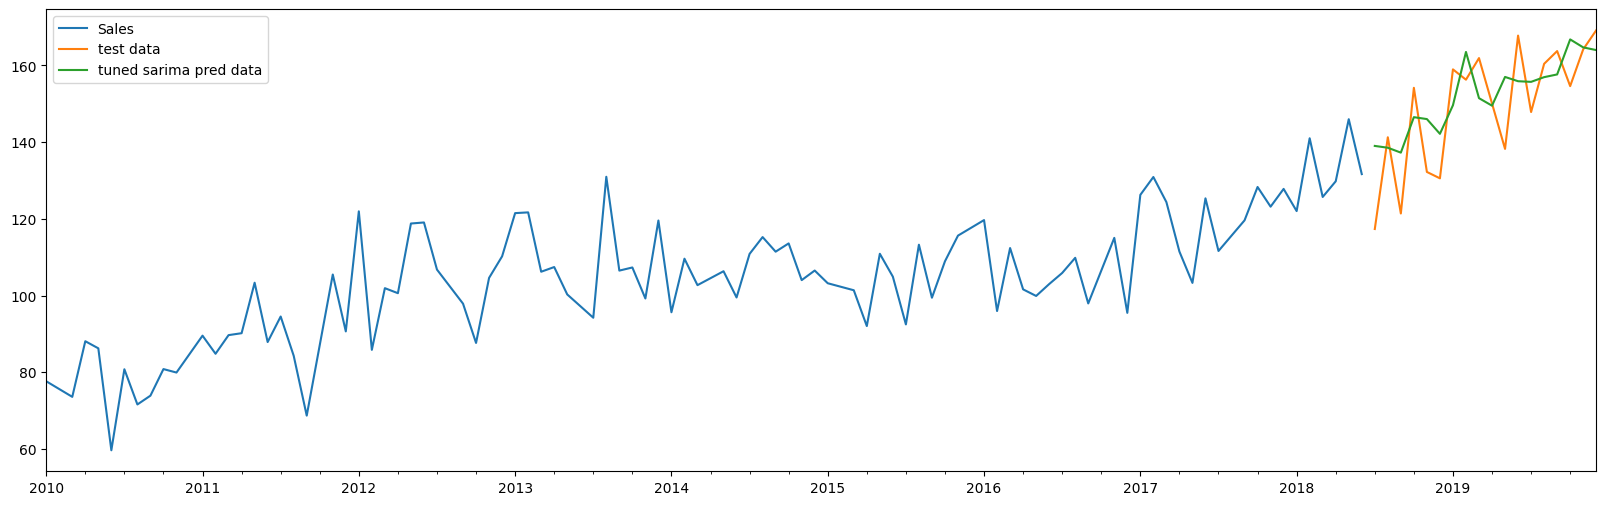

In [28]:
# Final tuned model

model_sarima_tuned = SARIMAX(train_x.Sales, order = (p, d, q), seasonal_order = (P, D, Q, S)).fit()
test_x['pred_data_sarima_final'] = model_sarima_tuned.forecast(24)

train_x.plot(label='train_data')
test_x.Sales.plot(label = 'test data')
test_x.pred_data_sarima_final.plot(label = 'tuned sarima pred data')

plt.legend()

performance(test_x.Sales, test_x.pred_data_sarima_final)